In [1]:
import numpy as np
import pandas as pd
import cv2
import seaborn as sns
import glob
import matplotlib.pyplot as plt

In [2]:
label_path = './input/labels.csv'
image_path = './input/head_ct/head_ct'

label_df = pd.read_csv(label_path)
image_files = sorted(glob.glob(image_path + '/*.png'))

In [3]:
labels = np.array(label_df[' hemorrhage'].tolist())

In [4]:
images = np.array([cv2.imread(file, cv2.IMREAD_GRAYSCALE) for file in image_files])
images.shape, images[0].shape

/home/ubuntu/miniconda3/envs/env/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


((200,), (957, 821))

In [5]:
images_df = pd.DataFrame(images, columns=['image'])
images_df['width'] = images_df['image'].apply(lambda x: x.shape[0])
images_df['height'] = images_df['image'].apply(lambda x: x.shape[1])
images_df['label'] = labels
images_df['label'] = images_df['label'].apply(lambda x: 'Not Hemorrhage' if x == 1 else 'Hemorrhage')

<AxesSubplot:xlabel='label', ylabel='count'>

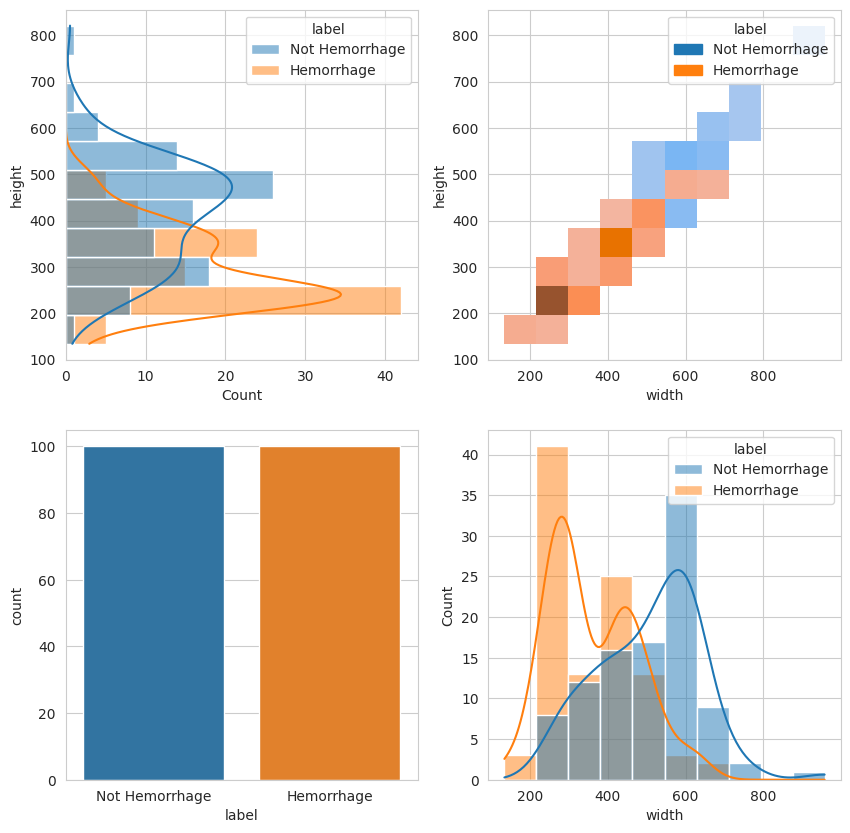

In [6]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
sns.histplot(x='width', data=images_df, ax=ax[1][1], hue='label', kde=True)
sns.histplot(y='height', data=images_df, ax=ax[0][0], hue='label', kde=True)
sns.histplot(x='width', y='height', data=images_df, ax=ax[0][1], hue='label')
sns.countplot(x='label', data=images_df, ax=ax[1][0])

In [7]:
from PIL import Image, ImageEnhance
def feature_engineering(img,size=(124,124)):
    img = Image.fromarray(img)  # openCV to PIL

    img = ImageEnhance.Contrast(img)  # 1 contrast enhancement
    contrast = 2
    img = img.enhance(contrast)
    img = np.asarray(img)  # PIL to openCV
    # img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)  # 2 gray scale
    thresh = (img.max() - img.min()) // 1.6  # binarize threshold
    _, img = cv2.threshold(img, thresh, 1, cv2.THRESH_BINARY)  # 3 binarize
    img = cv2.medianBlur(img, 7)  # 4 median blur
    img = cv2.erode(img, np.ones((3, 3), np.uint8), iterations=2)  # 5 erode
    img = cv2.resize(img, size)  # 6 resize

    return img

In [8]:
images_featured = np.array([feature_engineering(image) for image in images])

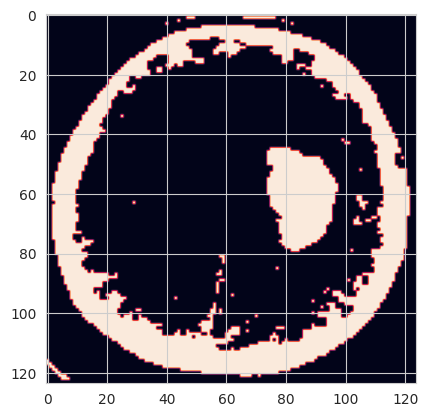

In [9]:
plt.imshow(images_featured[1])

In [10]:
images_featured=images_featured*255

In [79]:
for i in range(200):
    img = images_featured[i]
    cv2.imwrite('./exported/featured/{:03d}.png'.format(i), img)

In [7]:
 import keras
from keras import layers
from keras.layers import Input, Dense, Convolution2D, MaxPooling2D, UpSampling2D
from keras.models import Model

2023-06-04 14:20:50.869743: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-04 14:20:54.005046: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/ubuntu/miniconda3/envs/env/lib/python3.7/site-packages/cv2/../../lib64::/usr/local/cuda-11.6/lib64:/usr/local/cuda-11.6/lib64
2023-06-04 14:20:54.005538: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH

In [8]:
images_resized = np.array([cv2.resize(image, (124, 124)) for image in images])

In [37]:
import keras
from keras import layers

input_img = keras.Input(shape=(15376,))
encoded = layers.Dense(4096, activation='relu')(input_img)
encoded = layers.Dense(2048, activation='relu')(encoded)
encoded = layers.Dense(1024, activation='relu')(encoded)
encoded = layers.Dense(256, activation='relu')(encoded)
encoded = layers.Dense(128, activation='relu')(encoded)
encoded = layers.Dense(64, activation='relu')(encoded)
encoded = layers.Dense(32, activation='relu')(encoded)

decoded = layers.Dense(64, activation='relu')(encoded)
decoded = layers.Dense(128, activation='relu')(decoded)
decoded = layers.Dense(256, activation='relu')(decoded)
decoded = layers.Dense(1024, activation='relu')(decoded)
decoded = layers.Dense(2048, activation='relu')(decoded)
decoded = layers.Dense(4096, activation='relu')(decoded)
decoded = layers.Dense(15376, activation='sigmoid')(decoded)

encoder = keras.Model(input_img, encoded)
autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [52]:
import keras
from keras import layers


In [53]:
input_img = keras.Input(shape=(124, 124, 1))

x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

encoder = keras.Model(input_img, encoded)
autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.summary()

Model: "model_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 124, 124, 1)]     0         
                                                                 
 conv2d_47 (Conv2D)          (None, 124, 124, 16)      160       
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 62, 62, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_48 (Conv2D)          (None, 62, 62, 8)         1160      
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 31, 31, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_49 (Conv2D)          (None, 31, 31, 8)         584

In [27]:
image_flatten = np.array([image.flatten() for image in images_resized])

In [80]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(images_featured, labels, test_size=0.2)
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 124, 124))
x_test = np.reshape(x_test, (len(x_test), 124, 124))
x_train_3d = np.reshape(x_train, (len(x_train), 124, 124, 1))
x_test_3d = np.reshape(x_test, (len(x_test), 124, 124, 1))

In [81]:
autoencoder.fit(x_train_3d, x_train_3d,
                epochs=1000,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_3d, x_test_3d))
# autoencoder.fit(x_train, x_train,
#                 epochs=1000,
#                 batch_size=256,
#                 shuffle=True,
#                 validation_data=(x_test, x_test))

Epoch 1/1000
2/2 [==============================] - 0s 63ms/step - loss: 0.2192 - val_loss: 0.2604
Epoch 2/1000
2/2 [==============================] - 0s 44ms/step - loss: 0.2503 - val_loss: 0.2209
Epoch 3/1000
2/2 [==============================] - 0s 24ms/step - loss: 0.2155 - val_loss: 0.1900
Epoch 4/1000
2/2 [==============================] - 0s 54ms/step - loss: 0.1899 - val_loss: 0.1896
Epoch 5/1000
2/2 [==============================] - 0s 38ms/step - loss: 0.1888 - val_loss: 0.2026
Epoch 6/1000
2/2 [==============================] - 0s 58ms/step - loss: 0.1916 - val_loss: 0.2033
Epoch 7/1000
2/2 [==============================] - 0s 31ms/step - loss: 0.1947 - val_loss: 0.1804
Epoch 8/1000
2/2 [==============================] - 0s 26ms/step - loss: 0.1770 - val_loss: 0.1875
Epoch 9/1000
2/2 [==============================] - 0s 44ms/step - loss: 0.1810 - val_loss: 0.1830
Epoch 10/1000
2/2 [==============================] - 0s 28ms/step - loss: 0.1780 - val_loss: 0.1779
Epoch 11/

2/2 [==============================] - 0s 2ms/step


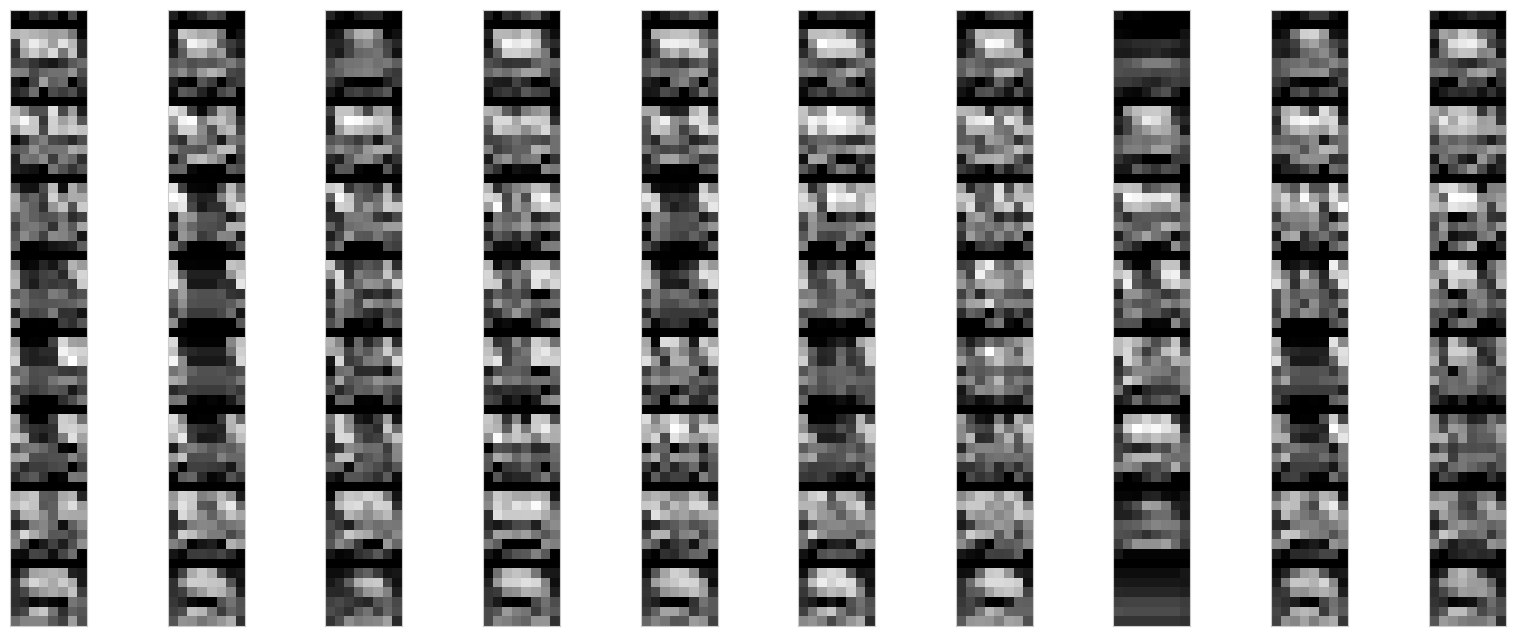

In [115]:
encoded_imgs = encoder.predict(x_test)

x=8
n = 10
plt.figure(figsize=(20, 8))
for i in range(1, n + 1):
    ax = plt.subplot(1, n, i)
    plt.imshow(encoded_imgs[i].reshape((x, 16*32//x)).T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

2/2 [==============================] - 0s 2ms/step


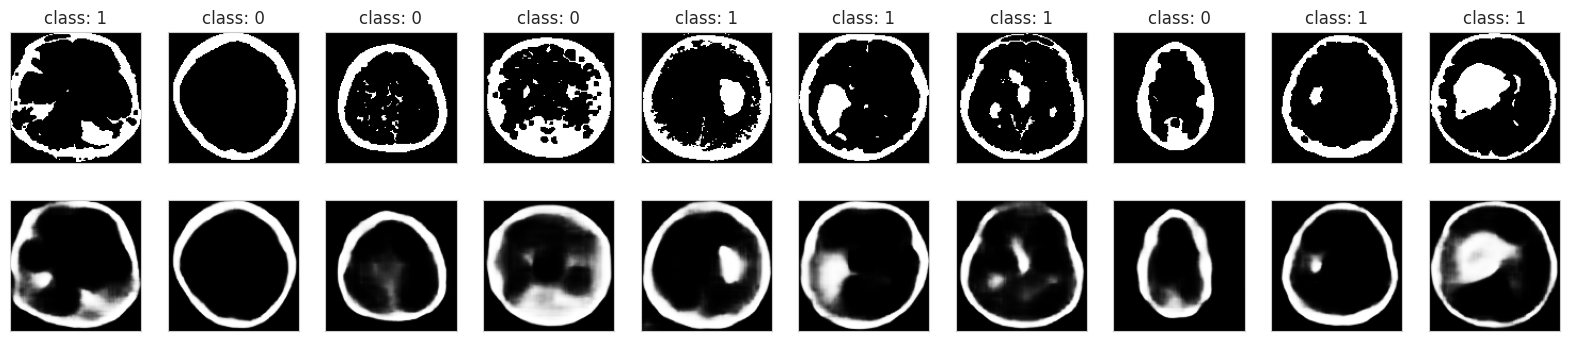

In [90]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(124, 124))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title('class: {}'.format(y_test[i]))

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(124, 124))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [245]:
encoded_imgs = (encoded_imgs-np.min(encoded_imgs))/(np.max(encoded_imgs)-np.min(encoded_imgs))
encoded_imgs = encoded_imgs * 255.
encoded_imgs = encoded_imgs.astype('uint8')

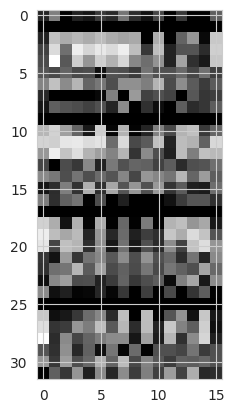

In [246]:
plt.imshow(encoded_imgs[0].reshape(16, 32).T)

In [369]:
images_featured.shape

(200, 124, 124)

In [370]:
target = images_featured
target = target.astype('float32') / 255.
target = np.reshape(target, (len(target), 124, 124, 1))

encoded_imgs = encoder.predict(target)
encoded_imgs = (encoded_imgs-np.min(encoded_imgs))/(np.max(encoded_imgs)-np.min(encoded_imgs))
encoded_imgs = encoded_imgs * 255.
encoded_imgs = encoded_imgs.astype('uint8')
# for i in range(200):
#     dimg = encoded_imgs[i].reshape(16, 32).T
#     cv2.imwrite('./exported/featured_encoded/{:03d}.png'.format(i), dimg)
#     hm = cv2.applyColorMap(dimg, cv2.COLORMAP_JET)
#     cv2.imwrite('./exported/featured_encoded_heatmaps/{:03d}.png'.format(i), hm)

7/7 [==============================] - 0s 2ms/step


In [371]:
encoded_imgs.shape,target.shape

((200, 8, 8, 8), (200, 124, 124, 1))

In [393]:
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
svmM={}

In [472]:
def metrics(model,X_test,y_test):
    acc = model.score(X_test, y_test) * 100
    print(acc)
    svm_y_pred = model.predict_proba(X_test)[:, 1]
    print(svm_y_pred)
    svm_fpr, svm_tpr, _ = roc_curve(y_test, svm_y_pred)
    svm_auc = auc(svm_fpr, svm_tpr)
    plt.figure()
    plt.plot(svm_fpr, svm_tpr, color='green', lw=2, label='SVM ROC curve (AUC = %0.2f)' % svm_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()  # 混淆矩阵
    svm_pred = model.predict(X_test)
    cfm = confusion_matrix(y_test, svm_pred)
    print("SVM Confusion Matrix: \n", cfm)
    sensitivity = cfm[0, 0] / (cfm[0, 0] + cfm[0, 1])
    print("Sensitivity : ", sensitivity)
    specificity = cfm[1, 1] / (cfm[1, 0] + cfm[1, 1])
    print("Specificity : ", specificity)
    precision = cfm[0, 0] / (cfm[0, 0] + cfm[1, 0])
    print("Precision : ", precision)
    F1score = 2*cfm[0, 0] / (2*cfm[0, 0] + cfm[0, 1] + cfm[1, 0])
    print("F1score : ", F1score)
    acc = (cfm[0, 0] + cfm[1, 1]) / (cfm[0, 0] + cfm[0, 1] + cfm[1, 0] + cfm[1, 1])
    print("Accuracy : ", acc)

In [396]:
# 编码featured

In [464]:
encoded_imgs = np.array([image.reshape(16,32) for image in encoded_imgs])
encoded_images_flatten = np.array([image.flatten() for image in encoded_imgs])
encoded_images_flatten.shape

(200, 512)

In [465]:
from sklearn import svm
from sklearn import datasets
from sklearn.model_selection import train_test_split as ts

The score of rbf is : 0.925000
The score of rbf is : 0.900000
The score of rbf is : 0.900000
The score of rbf is : 0.775000
The score of rbf is : 0.800000
The score of rbf is : 0.850000
The score of rbf is : 0.850000
The score of rbf is : 0.950000
The score of rbf is : 0.925000
The score of rbf is : 0.825000
The score of rbf is : 0.875000
The score of rbf is : 0.875000
The score of rbf is : 0.900000
The score of rbf is : 0.850000
The score of rbf is : 0.875000
The score of rbf is : 0.800000
The score of rbf is : 0.875000
The score of rbf is : 0.850000
The score of rbf is : 0.825000
The score of rbf is : 0.850000
The score of rbf is : 0.800000
The score of rbf is : 0.900000
The score of rbf is : 0.900000
The score of rbf is : 0.775000
The score of rbf is : 0.825000
The score of rbf is : 0.875000
The score of rbf is : 0.925000
The score of rbf is : 0.800000
The score of rbf is : 0.725000
The score of rbf is : 0.900000
The score of rbf is : 0.825000
The score of rbf is : 0.875000
The scor

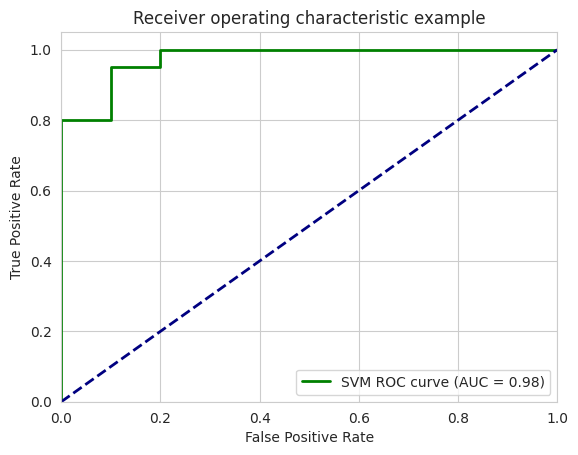

SVM Confusion Matrix: 
 [[18  2]
 [ 3 17]]
Sensitivity :  0.9
Specificity :  0.85
Precision :  0.8571428571428571
F1score :  0.8780487804878049
Accuracy :  0.875


In [473]:
sco=[]
bestmodel = None
for i in range(100):
    X_train, X_test, y_train, y_test = ts(encoded_images_flatten, labels, test_size=0.2)
    clf_rbf = svm.SVC(kernel='rbf',probability=True)
    clf_rbf.fit(X_train,y_train)
    score_rbf = clf_rbf.score(X_test,y_test)
    print("The score of rbf is : %f"%score_rbf)
    sco.append(score_rbf)
    if score_rbf>=np.max(sco):
        bestmodel = clf_rbf
print("编码featured mean",np.mean(sco))

X_train, X_test, y_train, y_test = ts(encoded_images_flatten, labels, test_size=0.2)
metrics(bestmodel,X_test,y_test)
svmM['编码featured'] = bestmodel

In [400]:
# 编码解码featured

In [401]:
decoded_imgs = autoencoder.predict(target)
decoded_imgs = (decoded_imgs-np.min(decoded_imgs))/(np.max(decoded_imgs)-np.min(decoded_imgs))
decoded_imgs = decoded_imgs * 255.
decoded_imgs = decoded_imgs.astype('uint8')
decoded_imgs = np.array([image.reshape(124,124) for image in decoded_imgs])
decoded_images_flatten = np.array([image.flatten() for image in decoded_imgs])
decoded_images_flatten.shape

7/7 [==============================] - 0s 2ms/step


(200, 15376)

The score of rbf is : 0.875000
The score of rbf is : 0.775000
The score of rbf is : 0.825000
The score of rbf is : 0.875000
The score of rbf is : 0.725000
The score of rbf is : 0.850000
The score of rbf is : 0.875000
The score of rbf is : 0.850000
The score of rbf is : 0.800000
The score of rbf is : 0.775000
The score of rbf is : 0.925000
The score of rbf is : 0.850000
The score of rbf is : 0.800000
The score of rbf is : 0.725000
The score of rbf is : 0.825000
The score of rbf is : 0.900000
The score of rbf is : 0.800000
The score of rbf is : 0.800000
The score of rbf is : 0.875000
The score of rbf is : 0.825000
The score of rbf is : 0.850000
The score of rbf is : 0.800000
The score of rbf is : 0.800000
The score of rbf is : 0.925000
The score of rbf is : 0.850000
The score of rbf is : 0.850000
The score of rbf is : 0.750000
The score of rbf is : 0.850000
The score of rbf is : 0.925000
The score of rbf is : 0.825000
The score of rbf is : 0.850000
The score of rbf is : 0.850000
The scor

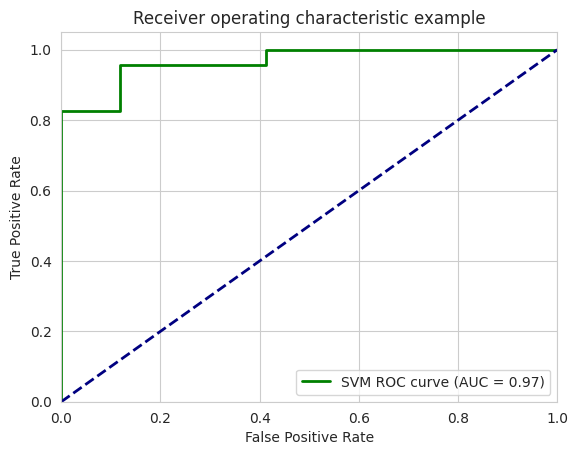

SVM Confusion Matrix: 
 [[15  2]
 [ 3 20]]
Sensitivity :  0.8823529411764706
Specificity :  0.8695652173913043
Precision :  0.8333333333333334
F1score :  0.8571428571428571
Accuracy :  0.875


In [402]:
sco=[]
bestmodel = None
for i in range(100):
    X_train, X_test, y_train, y_test = ts(decoded_images_flatten, labels, test_size=0.2)
    clf_rbf = svm.SVC(kernel='rbf',probability=True)
    clf_rbf.fit(X_train,y_train)
    score_rbf = clf_rbf.score(X_test,y_test)
    print("The score of rbf is : %f"%score_rbf)
    sco.append(score_rbf)
    if score_rbf>=np.max(sco):
        bestmodel = clf_rbf
print("编码解码featured mean",np.mean(sco))

X_train, X_test, y_train, y_test = ts(decoded_images_flatten, labels, test_size=0.2)
metrics(bestmodel,X_test,y_test)
svmM['编码解码featured'] = bestmodel

In [403]:
# featured

In [404]:
images_featured_cls = (images_featured-np.min(images_featured))/(np.max(images_featured)-np.min(images_featured))
images_featured_cls = images_featured_cls * 255.
images_featured_cls = images_featured_cls.astype('uint8')
images_featured_cls = np.array([image.reshape(124,124) for image in images_featured_cls])
images_featured_cls_flatten = np.array([image.flatten() for image in images_featured_cls])
images_featured_cls_flatten.shape

(200, 15376)

The score of rbf is : 0.875000
The score of rbf is : 0.775000
The score of rbf is : 0.800000
The score of rbf is : 0.775000
The score of rbf is : 0.875000
The score of rbf is : 0.750000
The score of rbf is : 0.750000
The score of rbf is : 0.825000
The score of rbf is : 0.700000
The score of rbf is : 0.800000
The score of rbf is : 0.875000
The score of rbf is : 0.825000
The score of rbf is : 0.825000
The score of rbf is : 0.800000
The score of rbf is : 0.800000
The score of rbf is : 0.875000
The score of rbf is : 0.775000
The score of rbf is : 0.725000
The score of rbf is : 0.725000
The score of rbf is : 0.850000
The score of rbf is : 0.800000
The score of rbf is : 0.800000
The score of rbf is : 0.825000
The score of rbf is : 0.725000
The score of rbf is : 0.850000
The score of rbf is : 0.675000
The score of rbf is : 0.675000
The score of rbf is : 0.775000
The score of rbf is : 0.675000
The score of rbf is : 0.725000
The score of rbf is : 0.775000
The score of rbf is : 0.825000
The scor

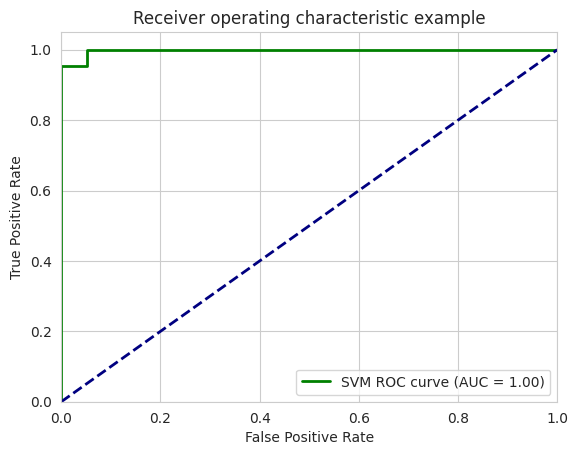

SVM Confusion Matrix: 
 [[19  0]
 [ 2 19]]
Sensitivity :  1.0
Specificity :  0.9047619047619048
Precision :  0.9047619047619048
F1score :  0.95
Accuracy :  0.95


In [418]:
sco=[]
bestmodel = None
for i in range(100):
    X_train, X_test, y_train, y_test = ts(images_featured_cls_flatten, labels, test_size=0.2)
    clf_rbf = svm.SVC(kernel='rbf',probability=True)
    clf_rbf.fit(X_train,y_train)
    score_rbf = clf_rbf.score(X_test,y_test)
    print("The score of rbf is : %f"%score_rbf)
    sco.append(score_rbf)
    if score_rbf>=np.max(sco):
        bestmodel = clf_rbf
print("featured mean",np.mean(sco))

X_train, X_test, y_train, y_test = ts(images_featured_cls_flatten, labels, test_size=0.2)
metrics(bestmodel,X_test,y_test)
svmM['featured'] = bestmodel

In [406]:
# 编码featuredHeatMap

In [407]:
encoded_imgs_cpy = np.array([image.reshape(16,32) for image in encoded_imgs])
encoded_imgs_cpy = np.array([cv2.applyColorMap(image,cv2.COLORMAP_JET) for image in encoded_imgs_cpy])
encoded_images_flatten = np.array([image.flatten() for image in encoded_imgs_cpy])
encoded_images_flatten.shape

(200, 1536)

The score of rbf is : 0.850000
The score of rbf is : 0.900000
The score of rbf is : 0.925000
The score of rbf is : 0.750000
The score of rbf is : 0.875000
The score of rbf is : 0.900000
The score of rbf is : 0.800000
The score of rbf is : 0.750000
The score of rbf is : 0.775000
The score of rbf is : 0.750000
The score of rbf is : 0.875000
The score of rbf is : 0.875000
The score of rbf is : 0.825000
The score of rbf is : 0.875000
The score of rbf is : 0.700000
The score of rbf is : 0.850000
The score of rbf is : 0.925000
The score of rbf is : 0.875000
The score of rbf is : 0.875000
The score of rbf is : 0.875000
The score of rbf is : 0.775000
The score of rbf is : 0.925000
The score of rbf is : 0.825000
The score of rbf is : 0.875000
The score of rbf is : 0.800000
The score of rbf is : 0.900000
The score of rbf is : 0.800000
The score of rbf is : 0.925000
The score of rbf is : 0.750000
The score of rbf is : 0.875000
The score of rbf is : 0.900000
The score of rbf is : 0.900000
The scor

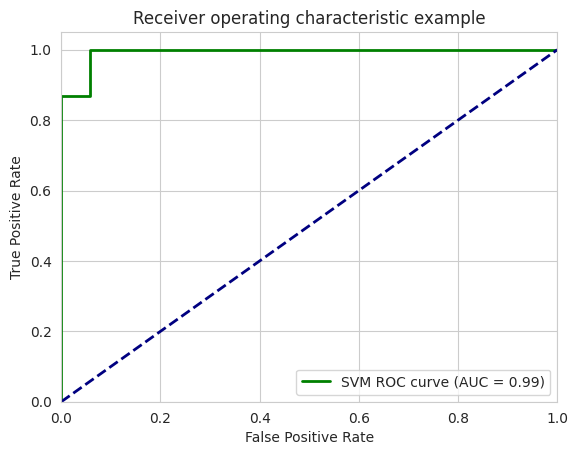

SVM Confusion Matrix: 
 [[16  1]
 [ 1 22]]
Sensitivity :  0.9411764705882353
Specificity :  0.9565217391304348
Precision :  0.9411764705882353
F1score :  0.9411764705882353
Accuracy :  0.95


In [408]:
sco=[]
bestmodel = None
for i in range(100):
    X_train, X_test, y_train, y_test = ts(encoded_images_flatten, labels, test_size=0.2)
    clf_rbf = svm.SVC(kernel='rbf',probability=True)
    clf_rbf.fit(X_train,y_train)
    score_rbf = clf_rbf.score(X_test,y_test)
    print("The score of rbf is : %f"%score_rbf)
    sco.append(score_rbf)
    if score_rbf>=np.max(sco):
        bestmodel = clf_rbf
print("编码featuredHeatMap",np.mean(sco))

X_train, X_test, y_train, y_test = ts(encoded_images_flatten, labels, test_size=0.2)
metrics(bestmodel,X_test,y_test)
svmM['编码featuredHeatMap'] = bestmodel

In [409]:
# 原始

In [410]:
images = np.array([cv2.resize(image,(124,124)) for image in images])
images_flatten = np.array([image.flatten() for image in images])

In [411]:
images_flatten.shape

(200, 15376)

The score of rbf is : 0.800000
The score of rbf is : 0.750000
The score of rbf is : 0.850000
The score of rbf is : 0.750000
The score of rbf is : 0.800000
The score of rbf is : 0.675000
The score of rbf is : 0.850000
The score of rbf is : 0.800000
The score of rbf is : 0.725000
The score of rbf is : 0.675000
The score of rbf is : 0.850000
The score of rbf is : 0.750000
The score of rbf is : 0.850000
The score of rbf is : 0.675000
The score of rbf is : 0.850000
The score of rbf is : 0.675000
The score of rbf is : 0.825000
The score of rbf is : 0.825000
The score of rbf is : 0.700000
The score of rbf is : 0.850000
The score of rbf is : 0.825000
The score of rbf is : 0.825000
The score of rbf is : 0.800000
The score of rbf is : 0.650000
The score of rbf is : 0.775000
The score of rbf is : 0.750000
The score of rbf is : 0.750000
The score of rbf is : 0.725000
The score of rbf is : 0.675000
The score of rbf is : 0.700000
The score of rbf is : 0.825000
The score of rbf is : 0.825000
The scor

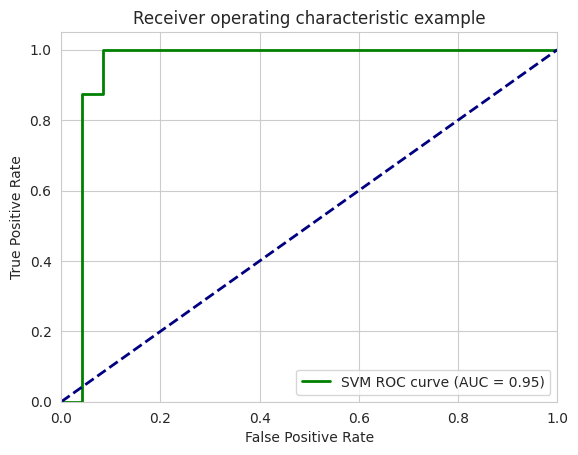

SVM Confusion Matrix: 
 [[22  2]
 [ 0 16]]
Sensitivity :  0.9166666666666666
Specificity :  1.0
Precision :  1.0
F1score :  0.9565217391304348
Accuracy :  0.95


In [412]:
sco=[]
bestmodel = None
for i in range(100):
    X_train, X_test, y_train, y_test = ts(images_flatten, labels, test_size=0.2)
    clf_rbf = svm.SVC(kernel='rbf',probability=True)
    clf_rbf.fit(X_train,y_train)
    score_rbf = clf_rbf.score(X_test,y_test)
    print("The score of rbf is : %f"%score_rbf)
    sco.append(score_rbf)
    if score_rbf>=np.max(sco):
        bestmodel = clf_rbf
print("原始",np.mean(sco))

X_train, X_test, y_train, y_test = ts(images_flatten, labels, test_size=0.2)
metrics(bestmodel,X_test,y_test)
svmM['原始'] = bestmodel

In [413]:
x_test.shape

(40, 124, 124)

In [392]:
images_resized.shape

(200, 124, 124)

In [ ]:
kf = KFold(n_splits=6, shuffle=True)
best_model = {}
best_model['score'] = -1
best_model['model'] = None
for train_index, test_index in kf.split(X_train):
    X_trainT, X_testT = images[train_index], images[test_index]
    y_trainT, y_testT = labels[train_index], labels[test_index]
    clf_rbf = svm.SVC(kernel='rbf',probability=True)
    clf_rbf.fit(X_trainT,y_trainT)
    score_rbf = clf_rbf.score(X_testT,y_testT)
    if score_rbf > best_model['score']:
        best_model['score'] = score_rbf
        best_model['model'] = clf_rbf

In [419]:
from keras.utils import np_utils
from keras.models import  Sequential
from keras.layers import  Dense,Dropout,Convolution2D,MaxPool2D,Flatten
from keras.optimizers import Adam

In [497]:
def cnn(input_shape):
    model=Sequential()
    '''
    #第一个卷积层
    input_shape  输入平面
    filters 卷积核个数
    kernal_size 卷积窗口大小
    stride 步长
    padding  same/valid
    activation 激活函数
    '''
    model.add(Convolution2D(
        input_shape=input_shape,
        filters=32,
        kernel_size=5,
        strides=1,
        padding='same',
        activation='relu',

    ))
    #第一个池化层
    model.add(MaxPool2D(
        pool_size=2,
        strides=2,
        padding='same',
    ))
    #第二个卷积层
    model.add(Convolution2D(64,5,strides=1,padding='same',activation='relu'))
    #第二个卷积层
    model.add(MaxPool2D(2,2,'same'))
    #把第二个卷积层输出扁平化为1维
    model.add(Flatten())
    #第一个全连接层
    model.add(Dense(1024,activation='relu'))
    #dropout
    model.add(Dropout(0.5))
    #第二个全连接层
    model.add(Dense(1,activation='sigmoid'))
    #定义优化器
    adam=Adam(learning_rate=1e-4)
    # 定义优化器，loss  function
    model.compile(optimizer=adam,loss='binary_crossentropy',metrics= [
        keras.metrics.TruePositives(name='tp'),
        keras.metrics.FalsePositives(name='fp'),
        keras.metrics.TrueNegatives(name='tn'),
        keras.metrics.FalseNegatives(name='fn'),
        keras.metrics.BinaryAccuracy(name='accuracy'),
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall'),
        keras.metrics.AUC(name='auc'),
        keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
    ])
    return model

In [498]:
def metrics2(model,X_test,y_test):
    svm_y_pred = model.predict(X_test)
    # print(svm_y_pred)
    #
    # svm_y_pred  = np.array([np.max(svm_y_pred[i]) for i in range(len(svm_y_pred))])
    #
    # print(svm_y_pred)
    # print(svm_y_pred.shape)

    svm_fpr, svm_tpr, _ = roc_curve(y_test, svm_y_pred)
    svm_auc = auc(svm_fpr, svm_tpr)
    plt.figure()
    plt.plot(svm_fpr, svm_tpr, color='green', lw=2, label='SVM ROC curve (AUC = %0.2f)' % svm_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()  # 混淆矩阵
    svm_pred = model.predict(X_test)
    cfm = confusion_matrix(y_test, svm_pred)
    print("SVM Confusion Matrix: \n", cfm)
    sensitivity = cfm[0, 0] / (cfm[0, 0] + cfm[0, 1])
    print("Sensitivity : ", sensitivity)
    specificity = cfm[1, 1] / (cfm[1, 0] + cfm[1, 1])
    print("Specificity : ", specificity)
    precision = cfm[0, 0] / (cfm[0, 0] + cfm[1, 0])
    print("Precision : ", precision)
    F1score = 2*cfm[0, 0] / (2*cfm[0, 0] + cfm[0, 1] + cfm[1, 0])
    print("F1score : ", F1score)
    acc = (cfm[0, 0] + cfm[1, 1]) / (cfm[0, 0] + cfm[0, 1] + cfm[1, 0] + cfm[1, 1])
    print("Accuracy : ", acc)

In [499]:
# 编码featured

In [500]:
encoded_imgs = np.array([image.reshape(16,32) for image in encoded_imgs])
encoded_imgs.shape

(200, 16, 32)

In [520]:
X_train, X_test, y_train, y_test = ts(encoded_imgs, labels, test_size=0.2)
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size=0.2)
model = cnn((16,32,1))
model.summary()
hist=model.fit(X_train,y_train,epochs=1000,batch_size=128,validation_data=(X_val,y_val))
loss,accuracy=model.evaluate(X_test,y_test)
print('\ntest loss',loss)
print('accuracy',accuracy)

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_100 (Conv2D)         (None, 16, 32, 32)        832       
                                                                 
 max_pooling2d_64 (MaxPoolin  (None, 8, 16, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_101 (Conv2D)         (None, 8, 16, 64)         51264     
                                                                 
 max_pooling2d_65 (MaxPoolin  (None, 4, 8, 64)         0         
 g2D)                                                            
                                                                 
 flatten_20 (Flatten)        (None, 2048)              0         
                                                                 
 dense_66 (Dense)            (None, 1024)            

ValueError: too many values to unpack (expected 2)

2/2 [==============================] - 0s 2ms/step


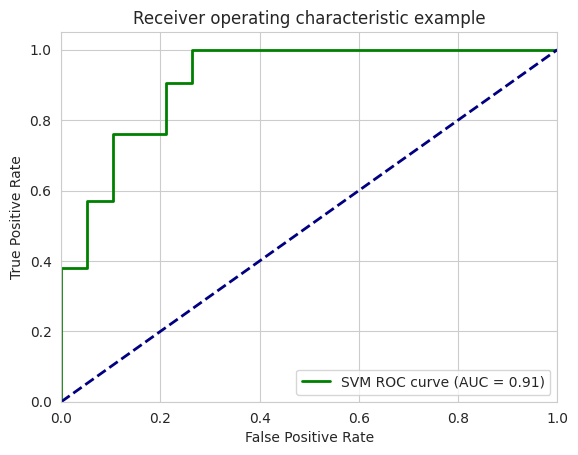

2/2 [==============================] - 0s 2ms/step


ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [535]:
metrics2(model,X_test,y_test)

In [522]:
baseline_results = model.evaluate(X_test, y_test, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
    print(name, ': ', value)
print()

loss :  1.0955768823623657
tp :  15.0
fp :  2.0
tn :  17.0
fn :  6.0
accuracy :  0.800000011920929
precision :  0.8823529481887817
recall :  0.7142857313156128
auc :  0.897243082523346
prc :  0.8544172048568726



In [523]:
def plot_metrics(history):
    metrics = ['loss', 'prc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color='red', label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color='red', linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])

        plt.legend()

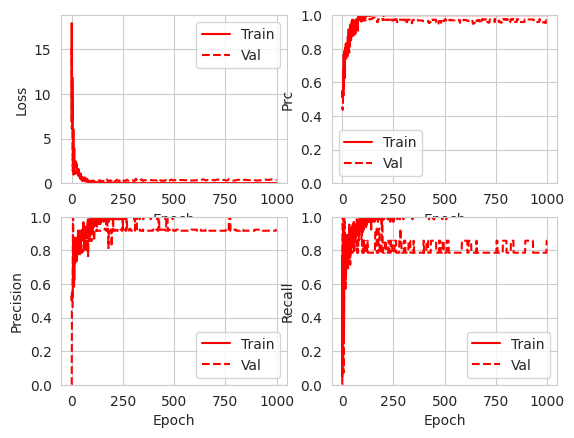

In [524]:
plot_metrics(hist)

In [525]:
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = roc_curve(labels, predictions)

    plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.xlim([-0.5,20])
    plt.ylim([80,100.5])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

2/2 [==============================] - 0s 2ms/step


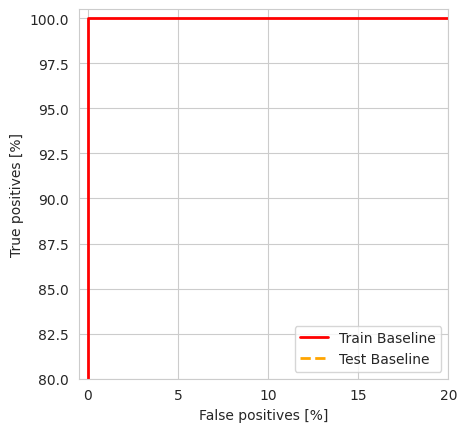

In [530]:
plot_roc("Train Baseline", y_train, model.predict(X_train), color='red')
plot_roc("Test Baseline", y_test, model.predict(X_test), color='orange', linestyle='--')
plt.legend(loc='lower right');

In [ ]:
# 编码解码featured

In [536]:
X_train, X_test, y_train, y_test = ts(decoded_imgs, labels, test_size=0.2)
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size=0.2)
model = cnn((124,124,1))
model.summary()
hist=model.fit(X_train,y_train,epochs=1000,batch_size=128,validation_data=(X_val,y_val))
loss,accuracy=model.evaluate(X_test,y_test)
print('\ntest loss',loss)
print('accuracy',accuracy)

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_102 (Conv2D)         (None, 124, 124, 32)      832       
                                                                 
 max_pooling2d_66 (MaxPoolin  (None, 62, 62, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_103 (Conv2D)         (None, 62, 62, 64)        51264     
                                                                 
 max_pooling2d_67 (MaxPoolin  (None, 31, 31, 64)       0         
 g2D)                                                            
                                                                 
 flatten_21 (Flatten)        (None, 61504)             0         
                                                                 
 dense_68 (Dense)            (None, 1024)            

ValueError: too many values to unpack (expected 2)

2/2 [==============================] - 0s 2ms/step


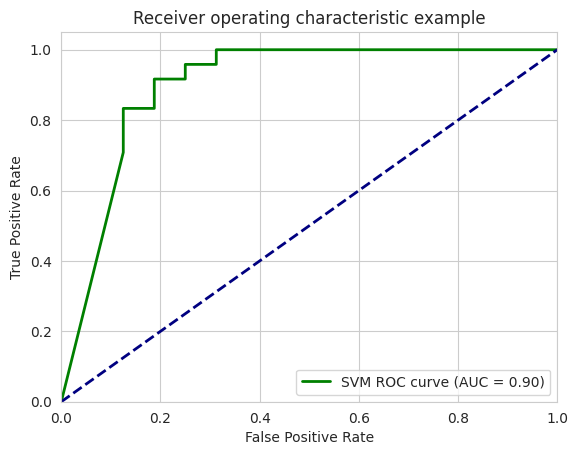

2/2 [==============================] - 0s 2ms/step


ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [537]:
metrics2(model,X_test,y_test)

In [538]:
baseline_results = model.evaluate(X_test, y_test, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
    print(name, ': ', value)
print()


loss :  2.907871723175049
tp :  22.0
fp :  3.0
tn :  13.0
fn :  2.0
accuracy :  0.875
precision :  0.8799999952316284
recall :  0.9166666865348816
auc :  0.8619791865348816
prc :  0.8654593825340271



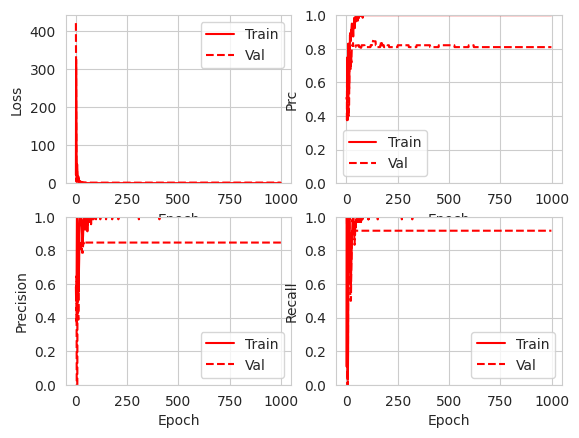

In [539]:
plot_metrics(hist)

In [540]:
# 编码featuredHeatmap

In [545]:
encoded_imgs_cpy = np.array([image.reshape(16,32) for image in encoded_imgs])
encoded_imgs_cpy = np.array([cv2.applyColorMap(image,cv2.COLORMAP_JET) for image in encoded_imgs_cpy])
X_train, X_test, y_train, y_test = ts(encoded_imgs_cpy, labels, test_size=0.2)
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size=0.2)
model = cnn((16,32,3))
model.summary()
hist=model.fit(X_train,y_train,epochs=1000,batch_size=128,validation_data=(X_val,y_val))
loss,accuracy=model.evaluate(X_test,y_test)
print('\ntest loss',loss)
print('accuracy',accuracy)

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_108 (Conv2D)         (None, 16, 32, 32)        2432      
                                                                 
 max_pooling2d_72 (MaxPoolin  (None, 8, 16, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_109 (Conv2D)         (None, 8, 16, 64)         51264     
                                                                 
 max_pooling2d_73 (MaxPoolin  (None, 4, 8, 64)         0         
 g2D)                                                            
                                                                 
 flatten_24 (Flatten)        (None, 2048)              0         
                                                                 
 dense_74 (Dense)            (None, 1024)            

ValueError: too many values to unpack (expected 2)

In [546]:
baseline_results = model.evaluate(X_test, y_test, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
    print(name, ': ', value)
print()

loss :  1.3499009609222412
tp :  20.0
fp :  0.0
tn :  17.0
fn :  3.0
accuracy :  0.925000011920929
precision :  1.0
recall :  0.8695651888847351
auc :  0.9309463500976562
prc :  0.9639628529548645



2/2 [==============================] - 0s 2ms/step


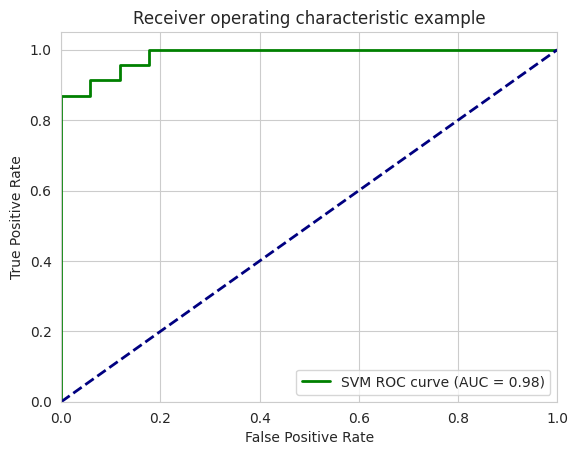

2/2 [==============================] - 0s 1ms/step


ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [547]:
metrics2(model,X_test,y_test)

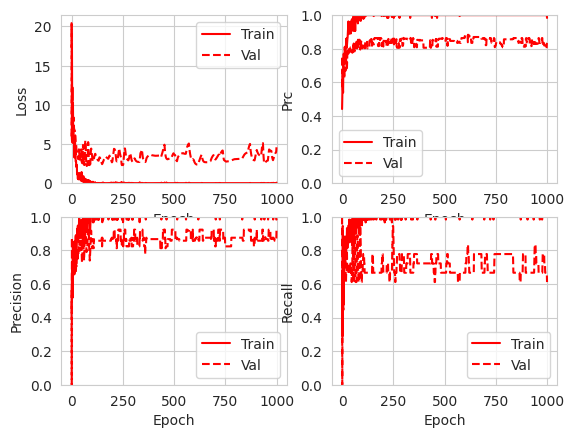

In [549]:
plot_metrics(hist)

In [ ]:
# featured

In [551]:
X_train, X_test, y_train, y_test = ts(images_featured_cls, labels, test_size=0.2)
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size=0.2)
model = cnn((124,124,1))
model.summary()
hist=model.fit(X_train,y_train,epochs=1000,batch_size=128,validation_data=(X_val,y_val))
loss,accuracy=model.evaluate(X_test,y_test)
print('\ntest loss',loss)
print('accuracy',accuracy)

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_112 (Conv2D)         (None, 124, 124, 32)      832       
                                                                 
 max_pooling2d_76 (MaxPoolin  (None, 62, 62, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_113 (Conv2D)         (None, 62, 62, 64)        51264     
                                                                 
 max_pooling2d_77 (MaxPoolin  (None, 31, 31, 64)       0         
 g2D)                                                            
                                                                 
 flatten_26 (Flatten)        (None, 61504)             0         
                                                                 
 dense_78 (Dense)            (None, 1024)            

ValueError: too many values to unpack (expected 2)

In [552]:
baseline_results = model.evaluate(X_test, y_test, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
    print(name, ': ', value)
print()

loss :  6.173644065856934
tp :  14.0
fp :  6.0
tn :  15.0
fn :  5.0
accuracy :  0.7250000238418579
precision :  0.699999988079071
recall :  0.7368420958518982
auc :  0.7506265640258789
prc :  0.7020236253738403



2/2 [==============================] - 0s 2ms/step


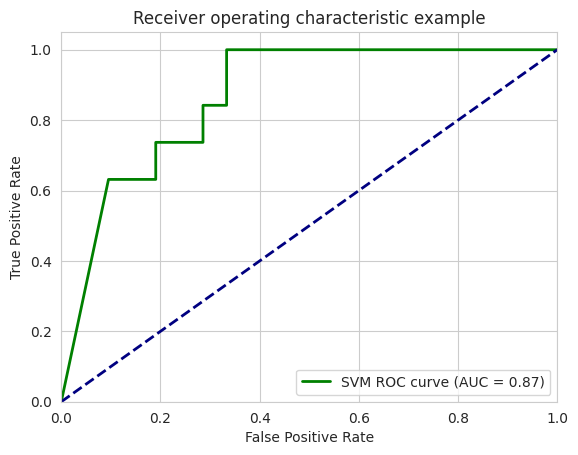

2/2 [==============================] - 0s 2ms/step


ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [553]:
metrics2(model,X_test,y_test)

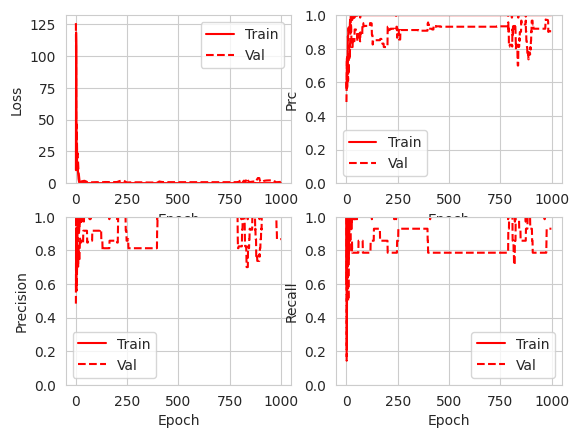

In [554]:
plot_metrics(hist)

In [555]:
# 原始

In [556]:
X_train, X_test, y_train, y_test = ts(images, labels, test_size=0.2)
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size=0.2)
model = cnn((124,124,1))
model.summary()
hist=model.fit(X_train,y_train,epochs=1000,batch_size=128,validation_data=(X_val,y_val))
loss,accuracy=model.evaluate(X_test,y_test)
print('\ntest loss',loss)
print('accuracy',accuracy)

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_114 (Conv2D)         (None, 124, 124, 32)      832       
                                                                 
 max_pooling2d_78 (MaxPoolin  (None, 62, 62, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_115 (Conv2D)         (None, 62, 62, 64)        51264     
                                                                 
 max_pooling2d_79 (MaxPoolin  (None, 31, 31, 64)       0         
 g2D)                                                            
                                                                 
 flatten_27 (Flatten)        (None, 61504)             0         
                                                                 
 dense_80 (Dense)            (None, 1024)            

ValueError: too many values to unpack (expected 2)

In [557]:
baseline_results = model.evaluate(X_test, y_test, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
    print(name, ': ', value)
print()

loss :  1.3507686853408813
tp :  11.0
fp :  1.0
tn :  20.0
fn :  8.0
accuracy :  0.7749999761581421
precision :  0.9166666865348816
recall :  0.5789473652839661
auc :  0.8746867179870605
prc :  0.8432618379592896



In [47]:
def knnHeat(cfm,auc):
    plt.figure(figsize=(5,4))
    sns.heatmap(cfm,annot=True,fmt='d',cmap='RdYlGn')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    sensitivity = cfm[0][0] / (cfm[0][0] + cfm[0][1])
    print("Sensitivity : ",sensitivity)
    specificity = cfm[1][1] / (cfm[1][0] + cfm[1][1])
    print("Specificity : ",specificity)
    precision = cfm[0][0] / (cfm[0][0] + cfm[1][0])
    print("Precision : ",precision)
    F1score = 2*cfm[0][0] / (2*cfm[0][0] + cfm[0][1] + cfm[1][0])
    print("F1score : ",F1score)
    acc = (cfm[0][0] + cfm[1][1]) / (cfm[0][0] + cfm[0][1] + cfm[1][0] + cfm[1][1])
    print("Accuracy : ", acc)
    plt.text(2.7,0.1,'Sensitivity = {:.3f}'.format(sensitivity))
    plt.text(2.7,0.4,'Specificity = {:.3f}'.format(specificity))
    plt.text(2.7,0.7,'Precision = {:.3f}'.format(precision))
    plt.text(2.7,1.0,'F1score = {:.3f}'.format(F1score))
    plt.text(2.7,1.3,'Accuracy = {:.3f}'.format(acc))
    plt.text(2.7,1.6,'AUC = {:.3f}'.format(auc))



Sensitivity :  0.9
Specificity :  0.6
Precision :  0.6923076923076923
F1score :  0.782608695652174
Accuracy :  0.75


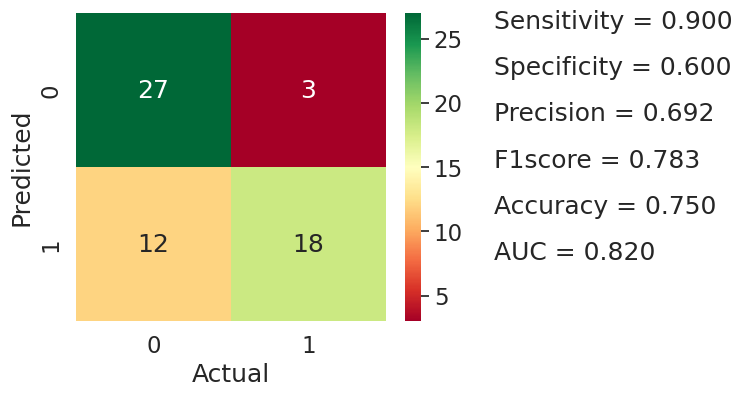

In [48]:
knnHeat([[27,3],[12,18]],0.82)

Sensitivity :  0.94
Specificity :  0.33666666666666667
Precision :  0.5862785862785863
F1score :  0.7221510883482715
Accuracy :  0.6383333333333333


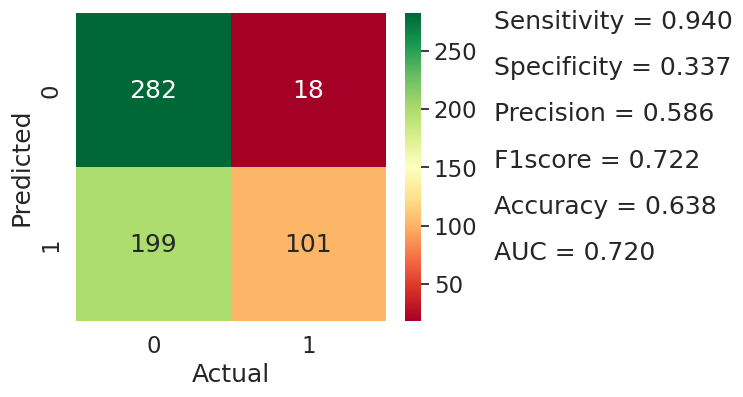

In [53]:
knnHeat([[282,18],[199,101]],0.72)

In [ ]:
def gen_mask(img, path):
    mask = np.zeros(img.shape[:2], dtype=np.uint8)
    for p in path:
        cv2.fillPoly(mask, [p], 255)
    return mask

In [ ]:
id = "067"

plt.subplot(1, 3, 1)
plt.imshow(images[int(id)])
plt.subplot(1, 3, 2)
plt.imshow(gen_mask(images[int(id)], parse_anno('./input/anno.xml', id + ".png")))
# 图像融合显示
plt.subplot(1, 3, 3)
plt.imshow(images[int(id)], alpha=0.5)
plt.imshow(gen_mask(images[int(id)], parse_anno('./input/anno.xml', id + ".png")), alpha=0.4)
plt.show()